(bayes_np_causal)=
# Bayesian Non-parametric Causal Inference

:::{post} January, 2024
:tags: bart, propensity scores, dirichlet process regression  
:category: advanced, reference
:author: Nathaniel
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

### Health Expenditure Data

In [352]:
df = pd.read_csv('../data/meps_bayes_np_health.csv', index_col=['Unnamed: 0'])
df = df[df['totexp'] > 0].reset_index(drop=True)
df['log_y'] = np.log(df['totexp'] + 1000)
df['loginc'] = np.log(df['income'])
df['smoke'] = np.where(df['smoke'] == 'No', 0, 1)
df

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,age,bmi,edu,income,povlev,region,sex,marital,race,seatbelt,smoke,phealth,totexp,log_y,loginc
0,30,39.1,14,78400,343.69,Northeast,Male,Married,White,Always,0,Fair,40,6.946976,11.269579
1,53,20.2,17,180932,999.30,West,Male,Married,Multi,Always,0,Very Good,429,7.264730,12.105877
2,81,21.0,14,27999,205.94,West,Male,Married,White,Always,0,Very Good,14285,9.634627,10.239924
3,77,25.7,12,27999,205.94,West,Female,Married,White,Always,0,Fair,7959,9.100414,10.239924
4,31,23.0,12,14800,95.46,South,Female,Divorced,White,Always,0,Excellent,5017,8.702344,9.602382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16425,23,26.6,16,23000,130.72,South,Male,Separated,Asian,Always,0,Very Good,130,7.029973,10.043249
16426,55,21.9,12,23000,130.72,South,Female,Married,Asian,Always,0,Very Good,468,7.291656,10.043249
16427,22,-9.0,9,7000,38.66,Midwest,Male,Married,White,Always,0,Excellent,711,7.444833,8.853665
16428,22,24.2,10,7000,38.66,Midwest,Female,Married,White,Always,0,Excellent,587,7.369601,8.853665


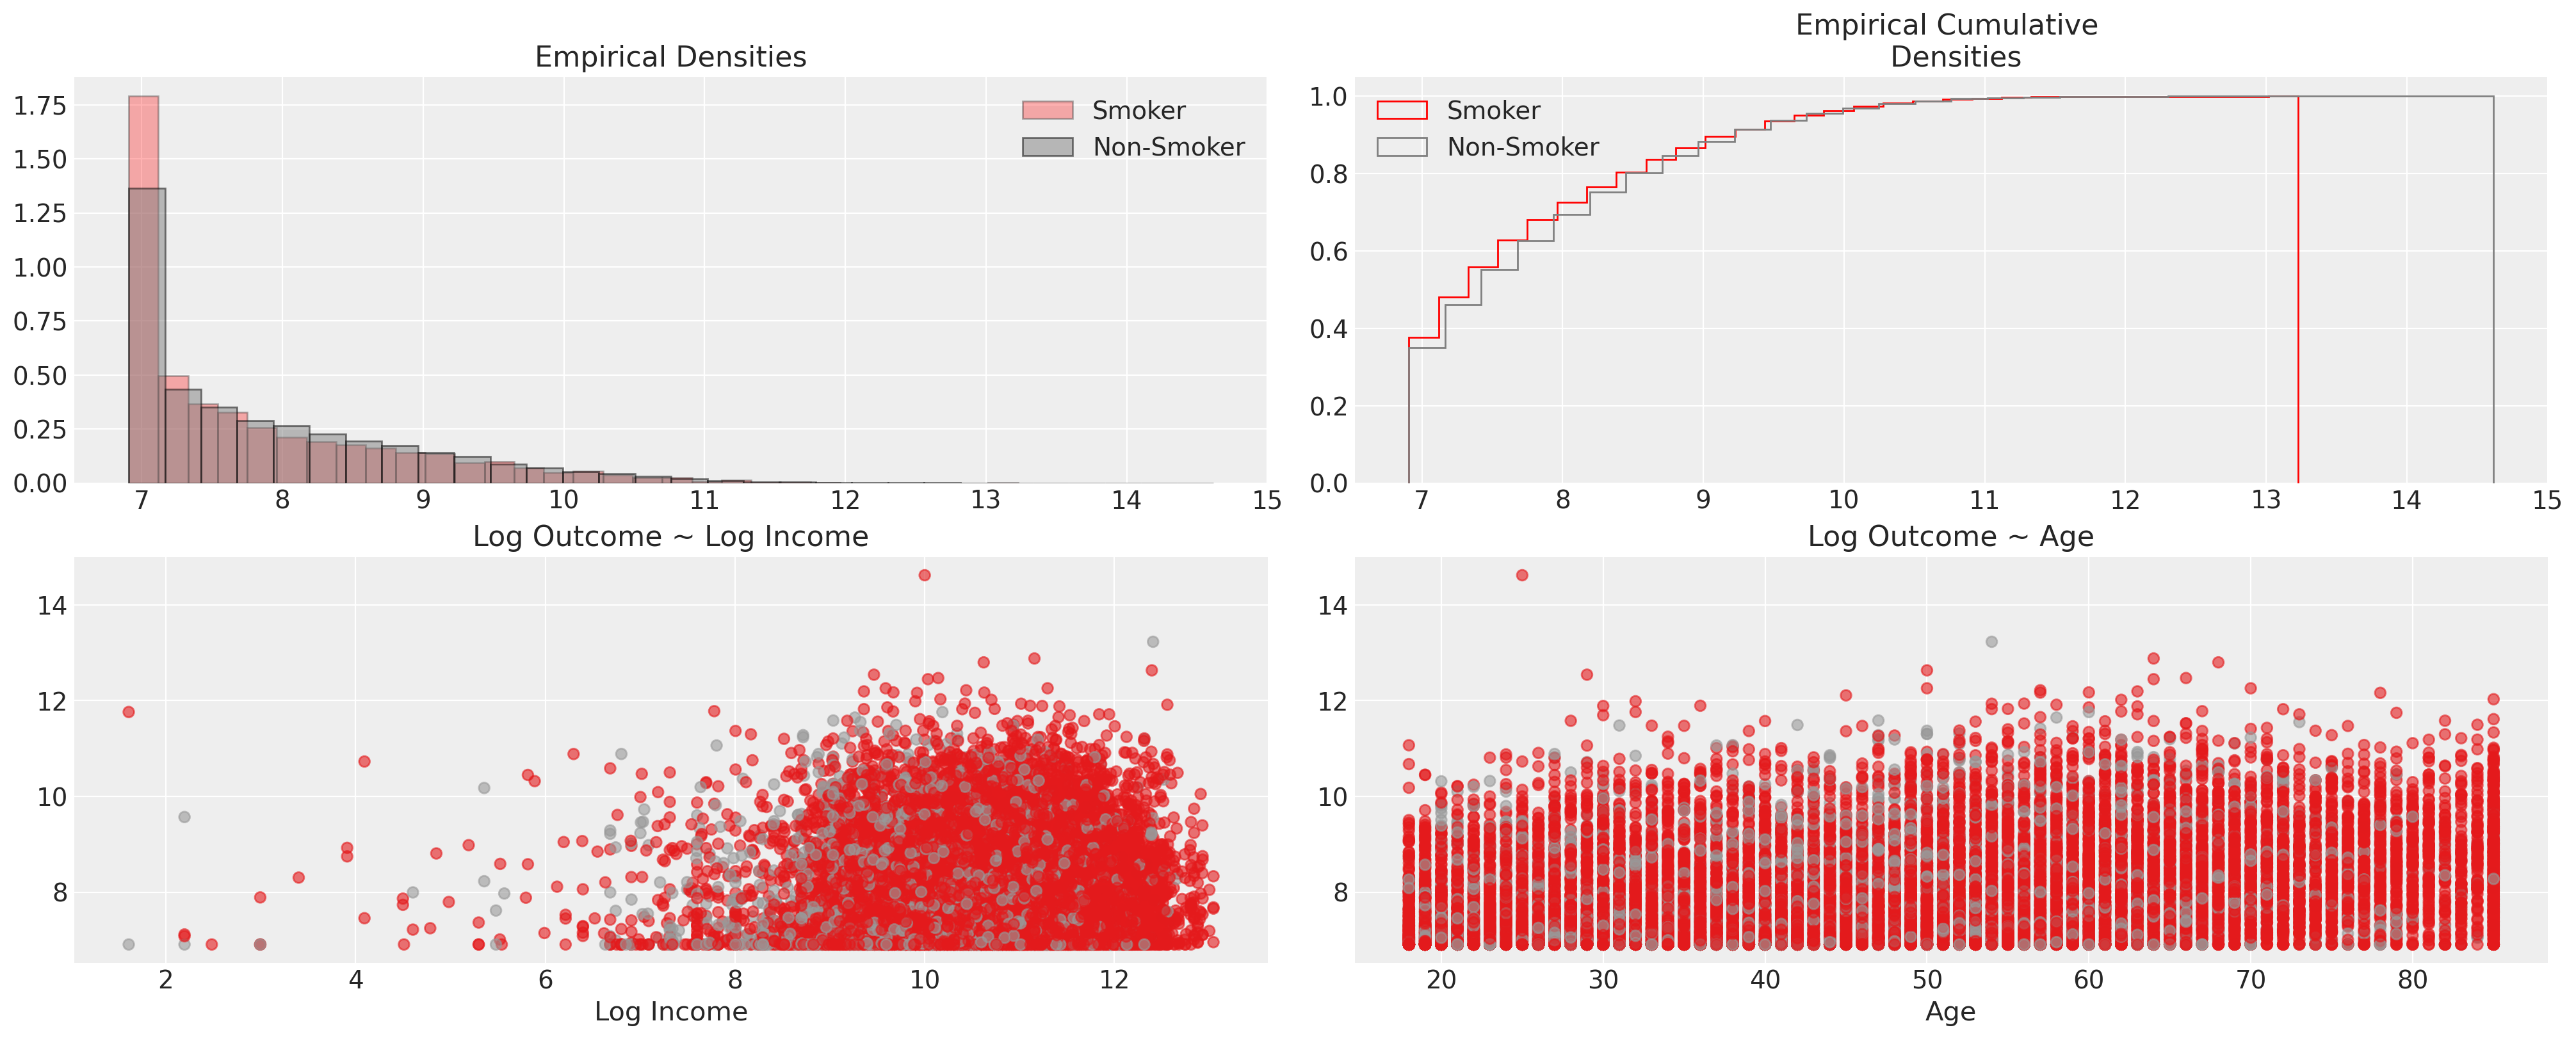

In [233]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
axs = axs.flatten()
axs[0].hist(df[df['smoke'] == 1]['log_y'], alpha=0.3, density=True, bins=30, label='Smoker', ec='black', color='red')
axs[0].hist(df[df['smoke'] == 0]['log_y'],  alpha=0.5, density=True, bins=30, label='Non-Smoker', ec='black', color='grey')
axs[1].hist(df[df['smoke'] == 1]['log_y'], density=True, bins=30, cumulative=True, histtype='step', label='Smoker', color='red')
axs[1].hist(df[df['smoke'] == 0]['log_y'], density=True, bins=30, cumulative=True, histtype='step', label='Non-Smoker', color='grey');
axs[2].scatter(df['loginc'], df['log_y'], c=df['smoke'], cmap='Set1', alpha=0.6)
axs[2].set_xlabel("Log Income")
axs[3].scatter(df['age'], df['log_y'], c=df['smoke'], cmap='Set1', alpha=0.6)

axs[3].set_title("Log Outcome ~ Age")
axs[2].set_title("Log Outcome ~ Log Income")
axs[3].set_xlabel("Age")
axs[0].set_title("Empirical Densities")
axs[0].legend()
axs[1].legend()
axs[1].set_title("Empirical Cumulative \n Densities");

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_80814/533968904.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  quantile_diff = (df.groupby('smoke')[['totexp']].quantile(qs).reset_index()


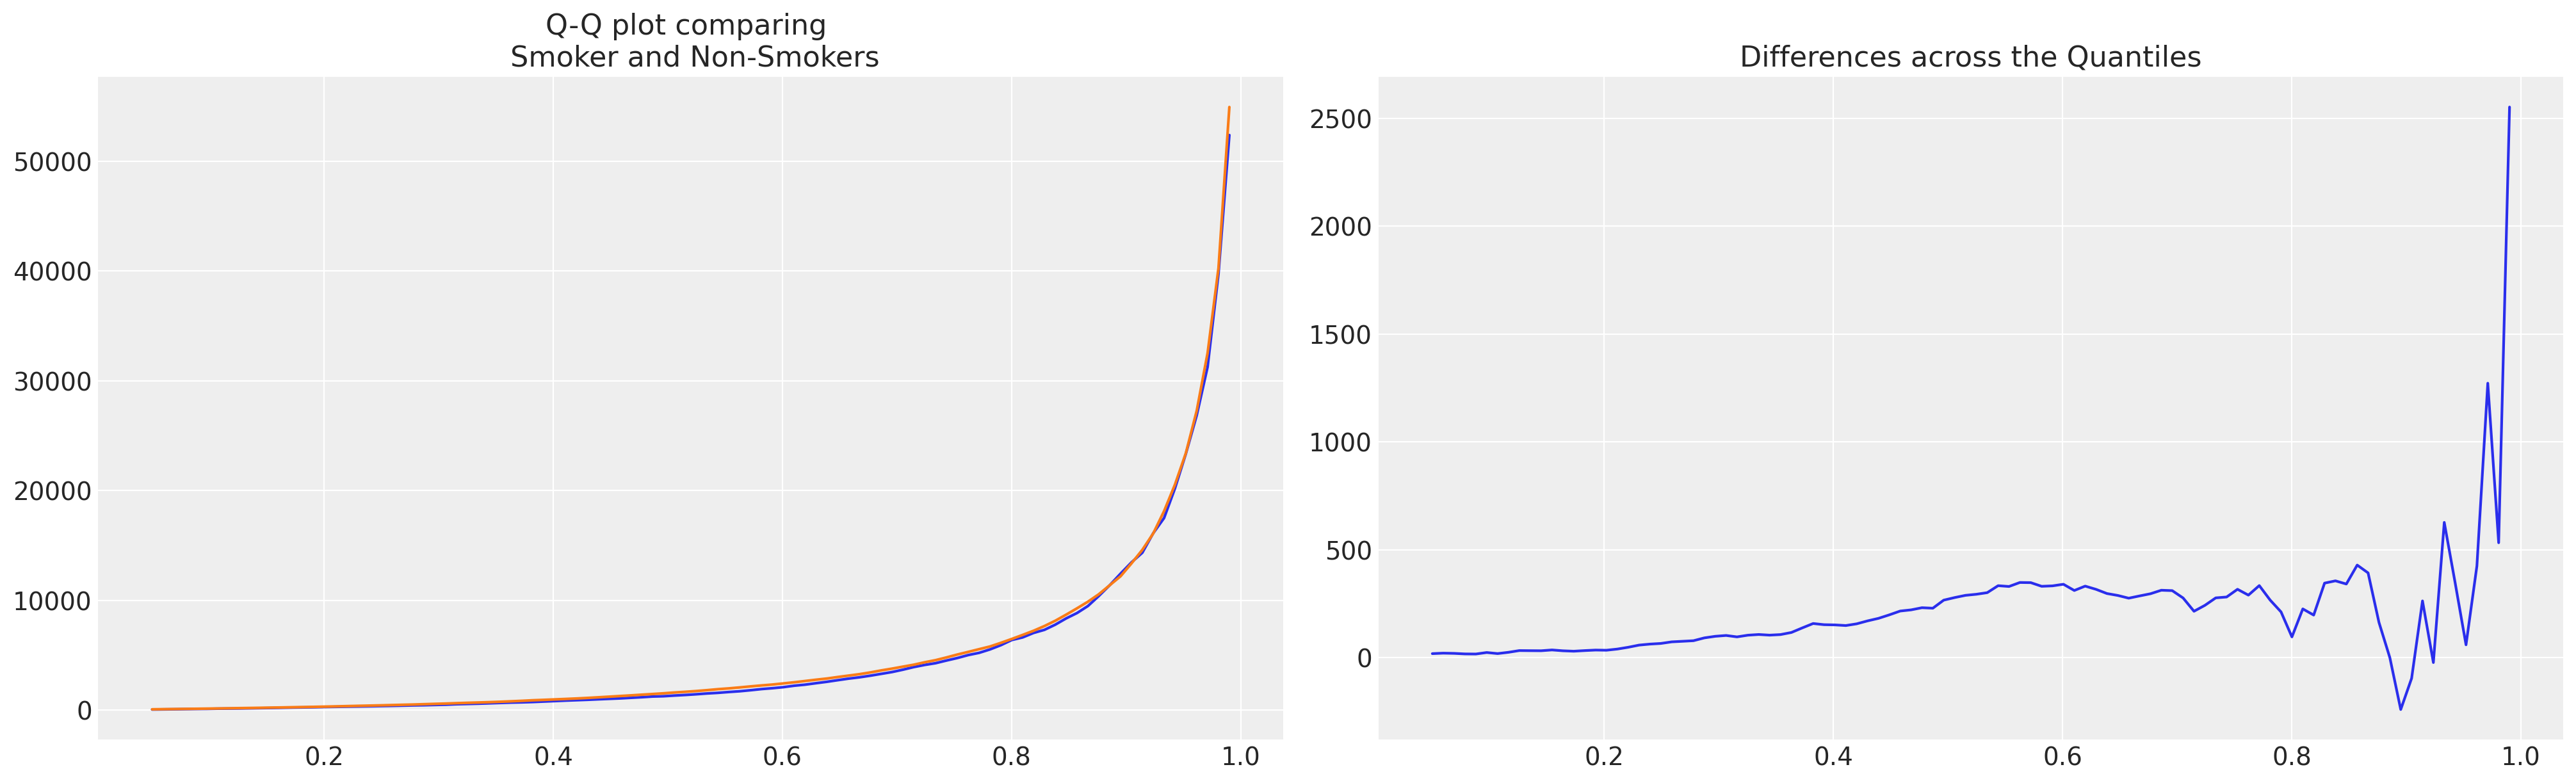

In [349]:
qs = np.linspace(0.05, 0.99, 100)
quantile_diff = (df.groupby('smoke')[['totexp']].quantile(qs).reset_index()
 .pivot('level_1', 'smoke', 'totexp').rename({0: 'Non-Smoker', 1: 'Smoker'}, axis=1)
 .assign(diff = lambda x: x['Non-Smoker'] - x['Smoker'])
 .reset_index().rename({'level_1': 'quantile'}, axis=1)
)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(quantile_diff['quantile'], quantile_diff['Smoker'])
axs[0].plot(quantile_diff['quantile'], quantile_diff['Non-Smoker'])
axs[0].set_title('Q-Q plot comparing \n Smoker and Non-Smokers')
axs[1].plot(quantile_diff['quantile'], quantile_diff['diff'])
axs[1].set_title("Differences across the Quantiles");

In [353]:
dummies = pd.concat(
    [
        pd.get_dummies(df["seatbelt"], drop_first=True, prefix='seatbelt'),
        pd.get_dummies(df["marital"], drop_first=True, prefix='marital'),
        pd.get_dummies(df["race"], drop_first=True, prefix='race'),
        pd.get_dummies(df["sex"], drop_first=True, prefix='sex'),
        pd.get_dummies(df["phealth"], drop_first=True, prefix='phealth'),

    ],
    axis=1,
)
idx = df.sample(1000).index
X = pd.concat([df[['age', 'loginc']], dummies], axis=1)
X = X.iloc[idx]
t = df.iloc[idx]['smoke']
y = df.iloc[idx]['log_y']
X['smoke'] = df['smoke']
X

,age,loginc,seatbelt_Always,seatbelt_Never,seatbelt_NoCar,seatbelt_Seldom,seatbelt_Sometimes,marital_Married,marital_Separated,marital_Widowed,...,race_Indig,race_Multi,race_PacificIslander,race_White,sex_Male,phealth_Fair,phealth_Good,phealth_Poor,phealth_Very Good,smoke
2022,52,11.589887,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
6506,27,10.373491,1,0,0,0,0,0,1,0,...,0,0,0,1,1,0,1,0,0,0
10403,21,11.794791,1,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
7596,45,11.176053,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
5068,47,11.726915,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,74,10.785063,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
14362,42,11.161338,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
11751,46,11.289782,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,1
8194,33,11.184421,1,0,0,0,0,0,1,0,...,0,0,0,1,1,1,0,0,0,0


### Quantile Models

Sampling: [mu, obs, sigma]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/math.py:1102: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1740: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/math.py:1102: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/math.py:1102: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-package

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


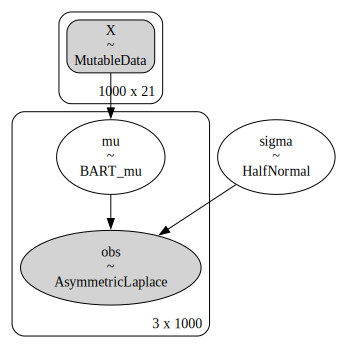

In [354]:
import pymc_bart as pmb

y_stack = np.stack([y]*3)
quantiles = np.array([[0.1, 0.5, 0.9]]).T

with pm.Model() as model_q:
    X_data = pm.MutableData('X', X)
    mu = pmb.BART("mu", X_data, y, shape=(3, X_data.shape[0]))
    sigma = pm.HalfNormal("sigma", 1)
    obs = pm.AsymmetricLaplace("obs", mu=mu, b=sigma, q=quantiles, observed=y_stack)
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())

pm.model_to_graphviz(model_q)

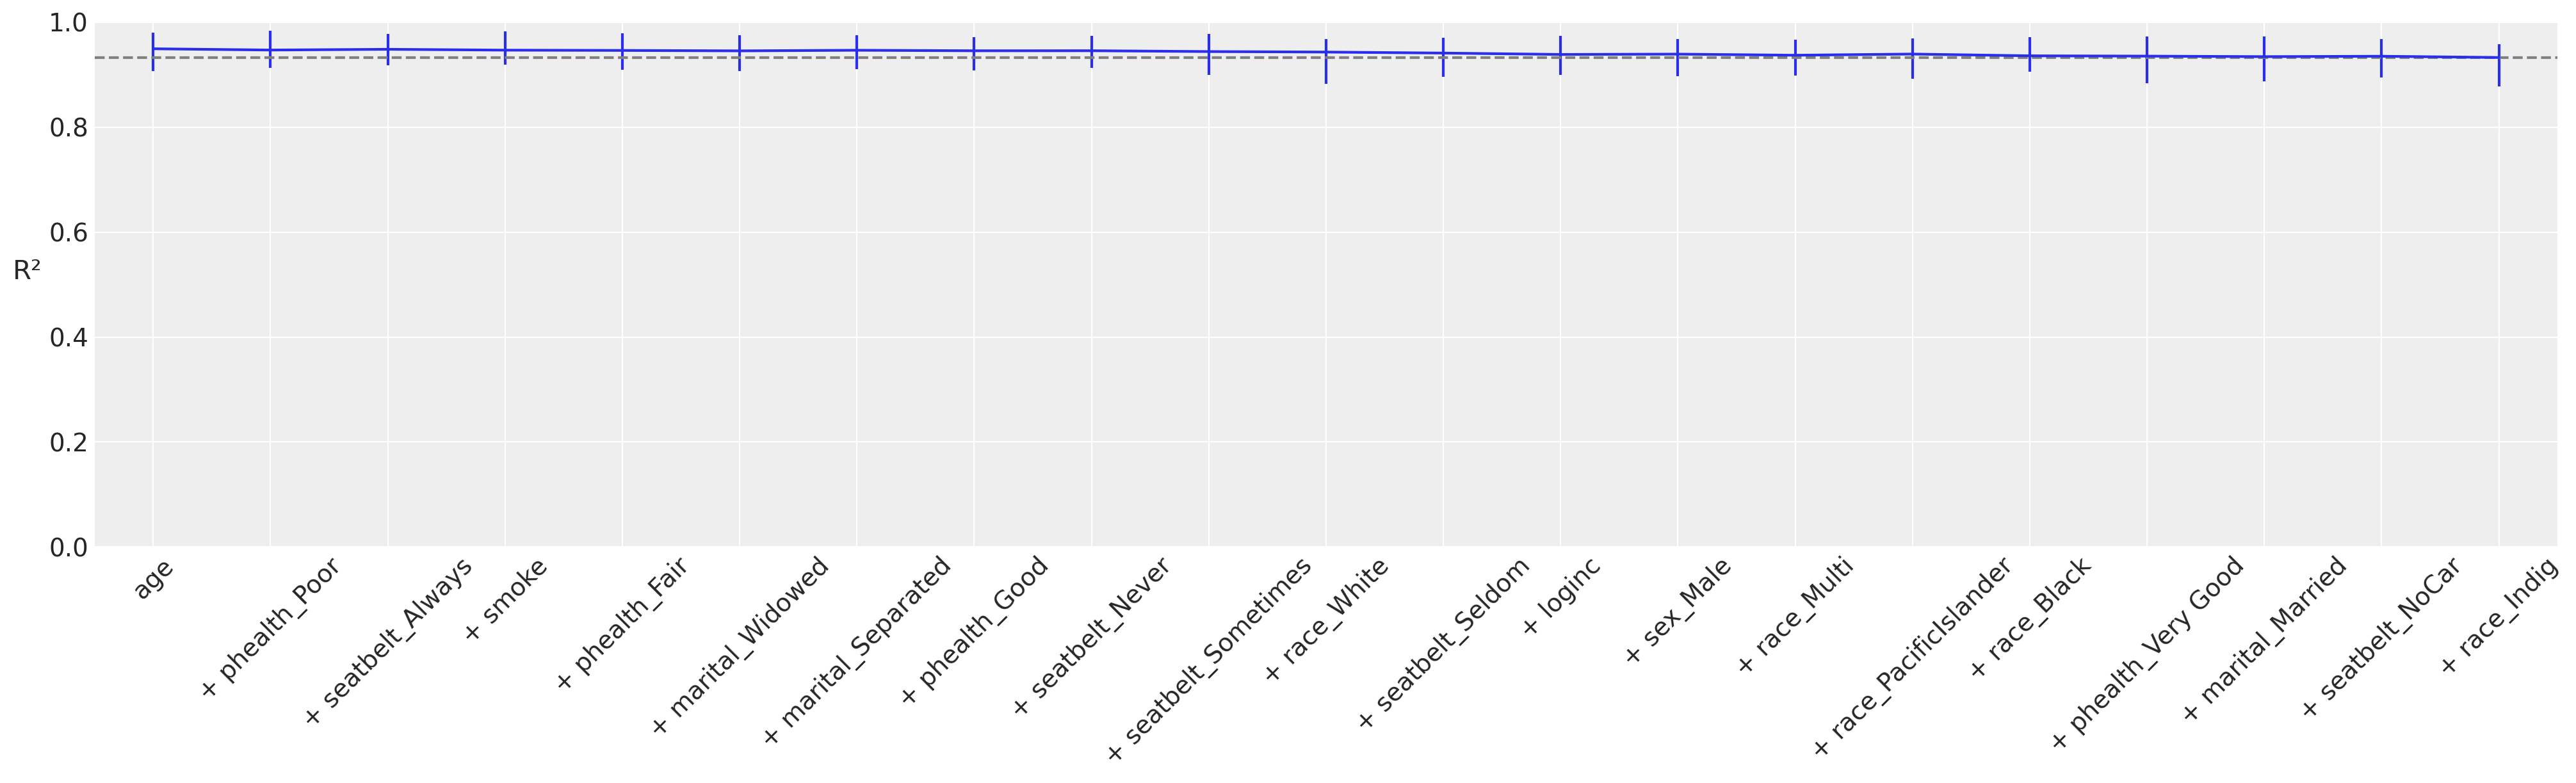

In [387]:
order, ax = pmb.plot_variable_importance(idata, bartrv=mu, X=X, figsize=(20, 6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

(30, 1000, 3)


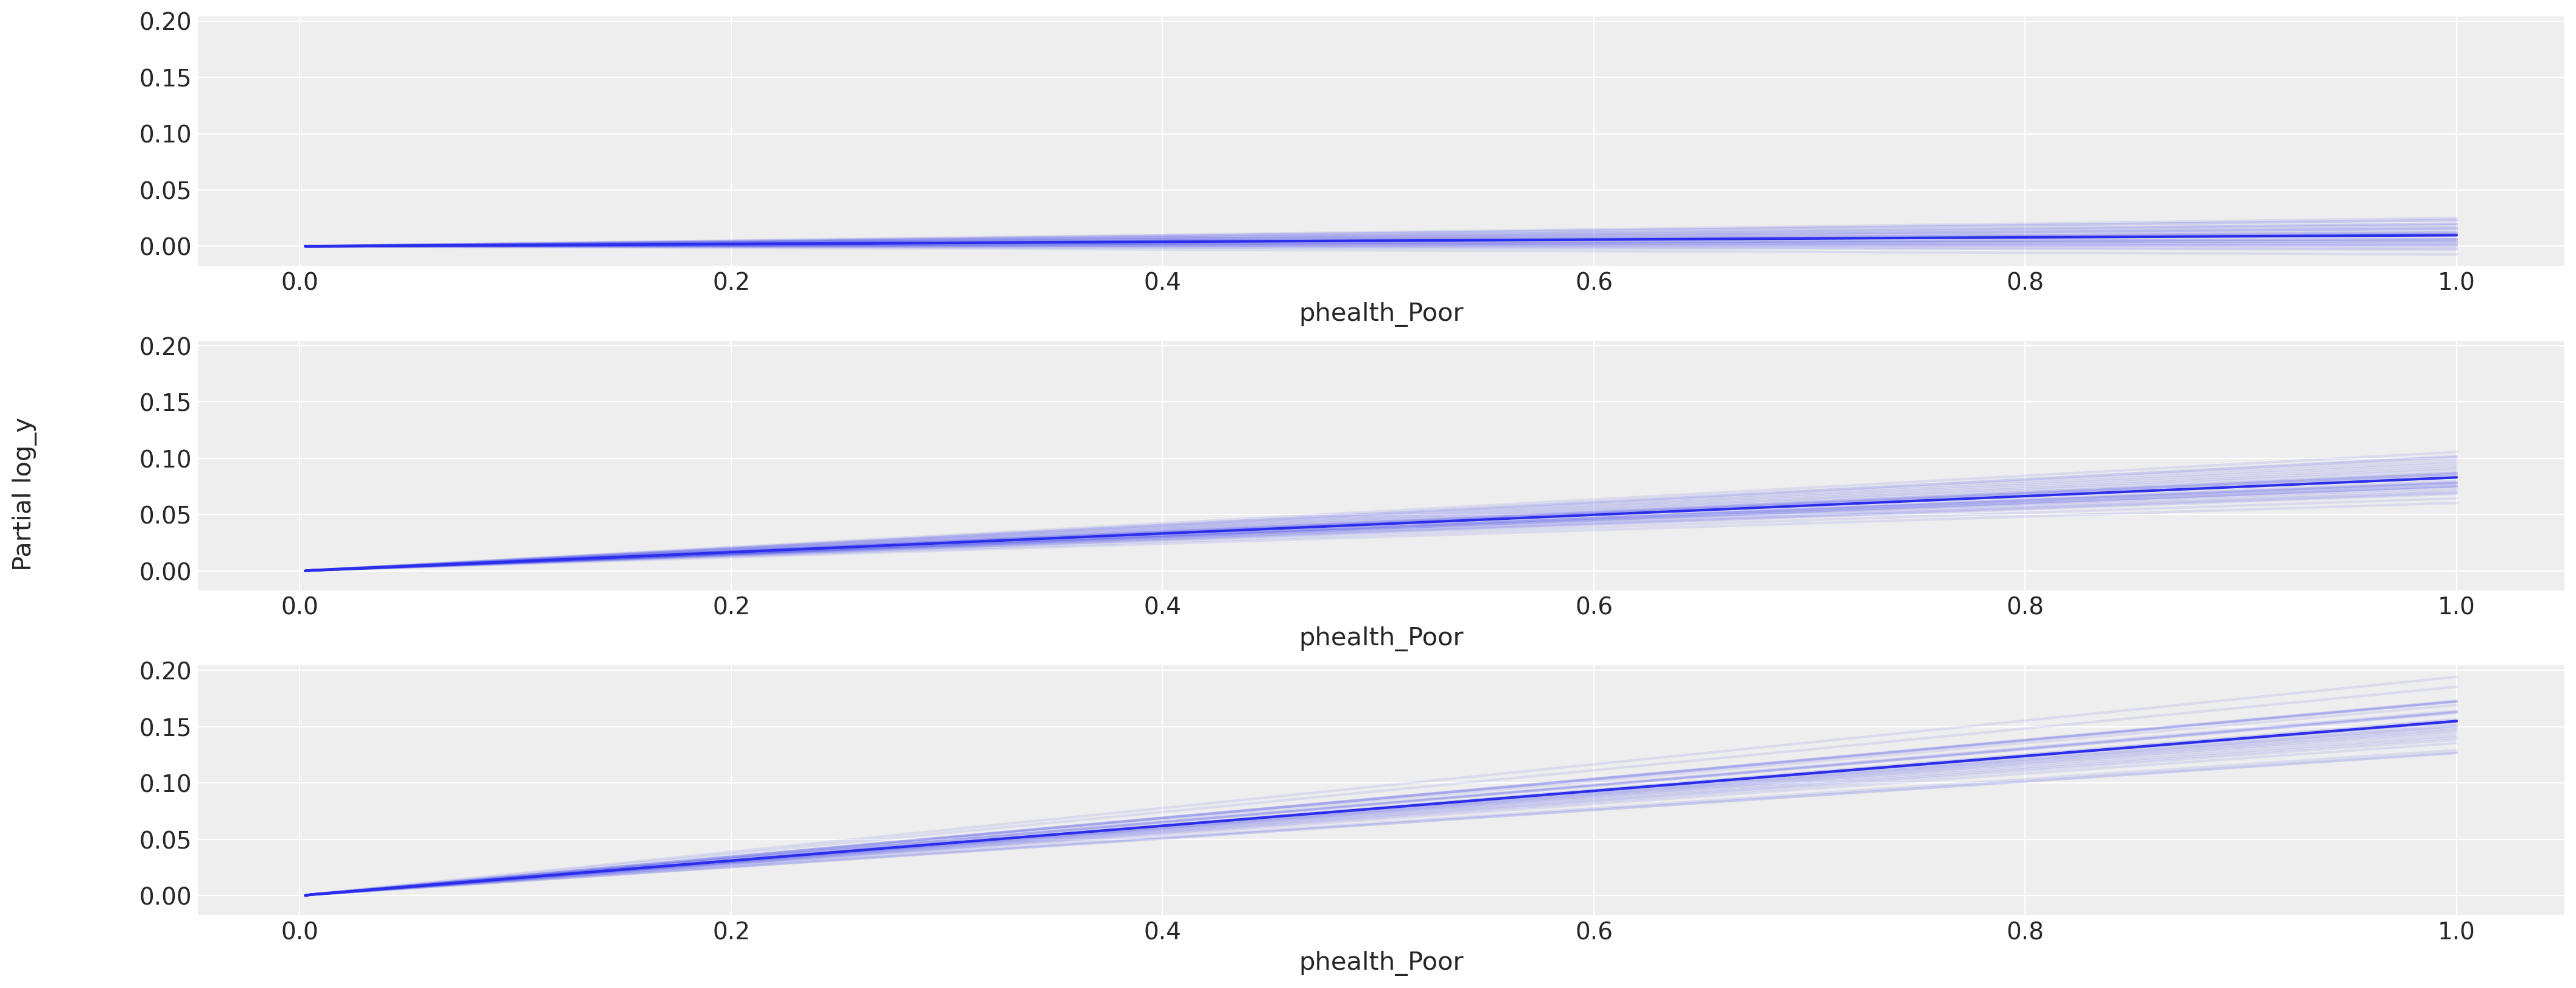

In [394]:
pmb.plot_ice(mu, X, y, var_idx=[18], figsize=(20, 8));

(30, 1000, 3)


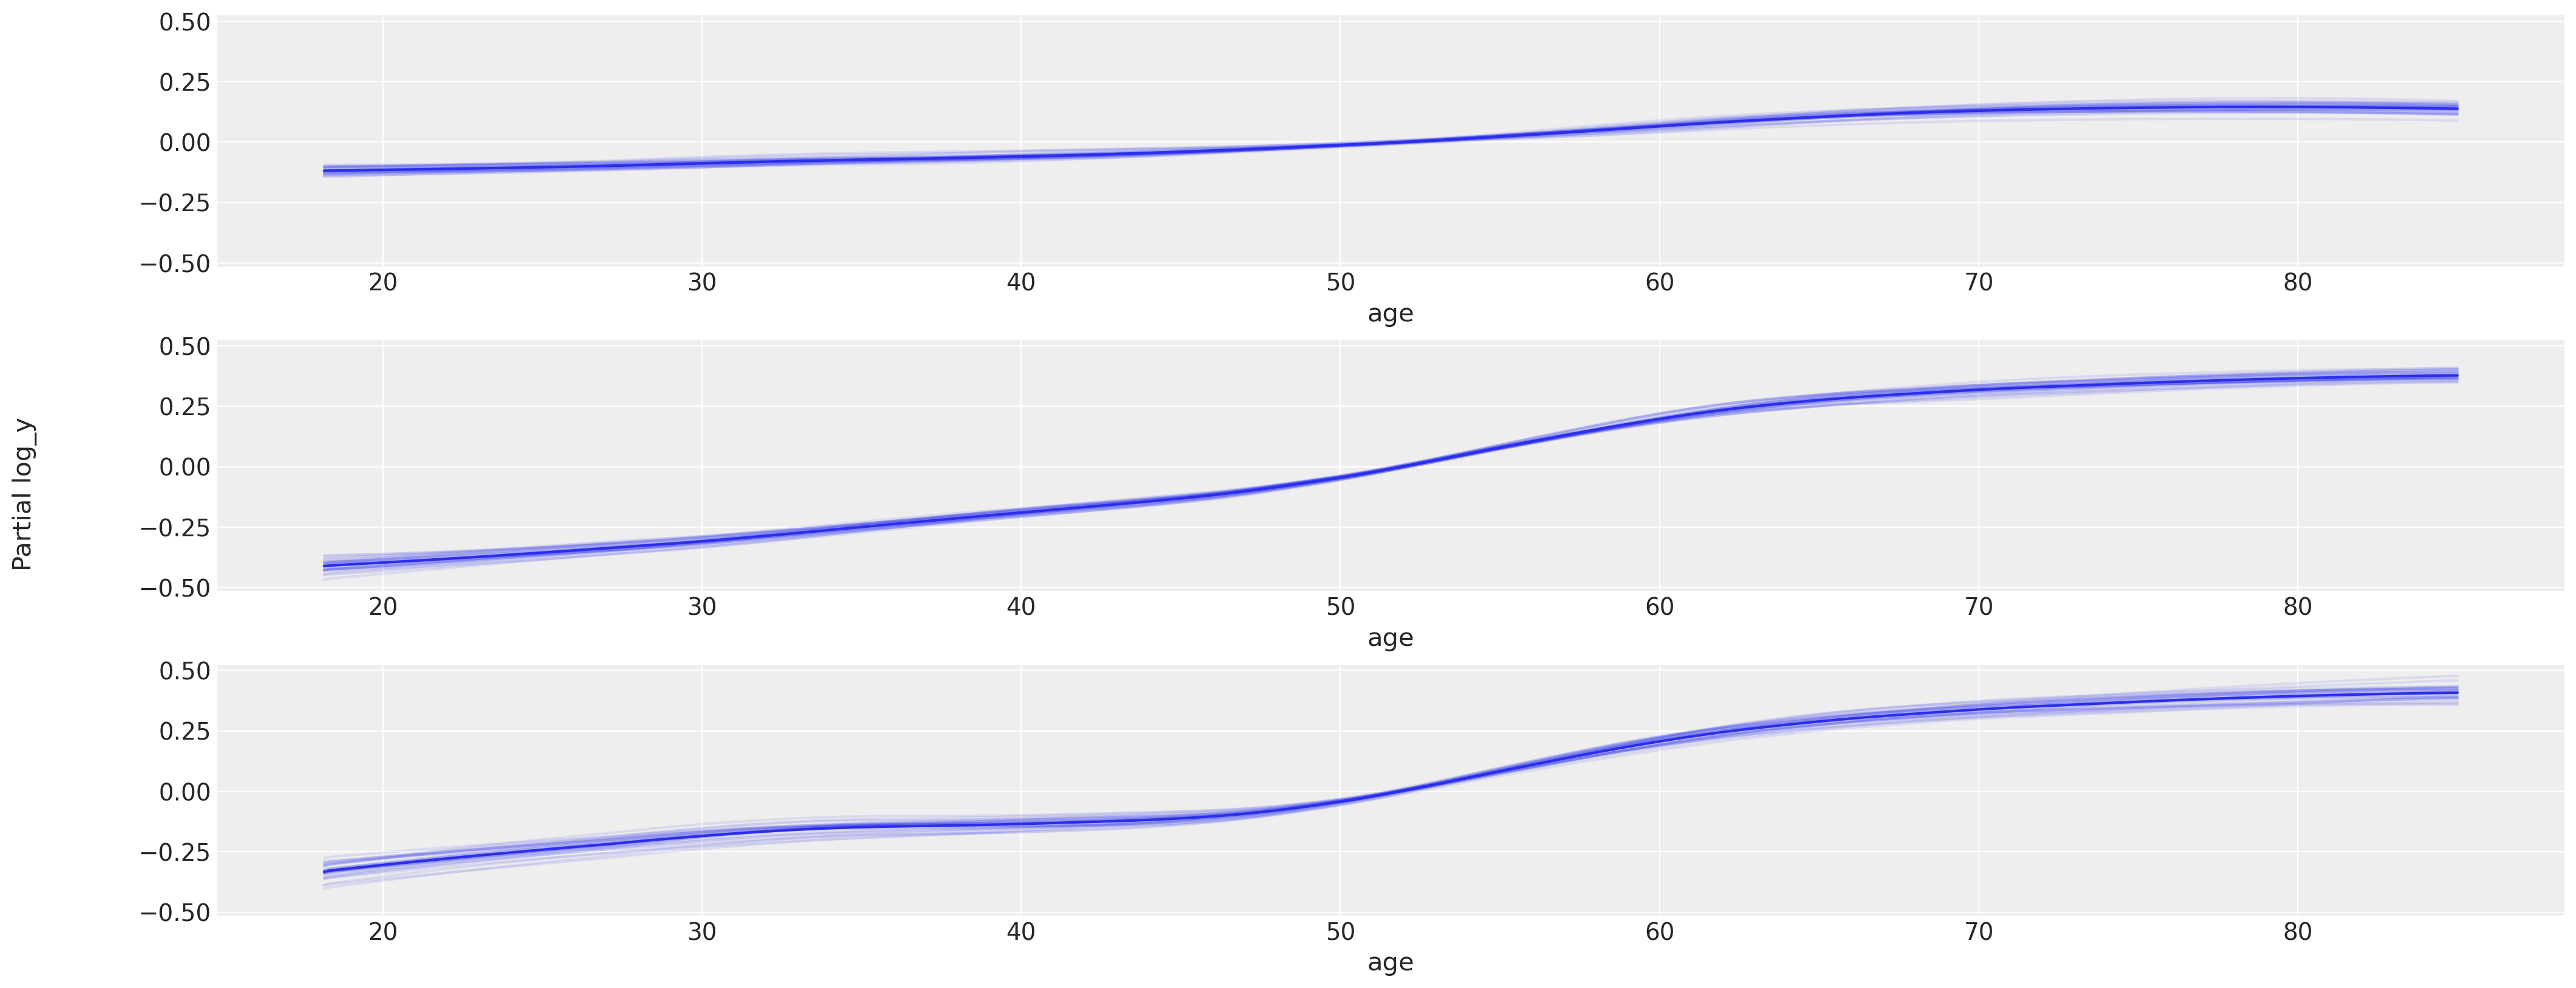

In [397]:
pmb.plot_ice(mu, X, y, var_idx=[0], figsize=(20, 8));

### Inferred Quantile Causal Effects

In [356]:
X['smoke'] = 1
with model_q:
    # update values of predictors:
    pm.set_data({"X": X})
    idata_smoke = pm.sample_posterior_predictive(idata)

idata_smoke

Sampling: [mu, obs]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [357]:
X['smoke'] = 0
with model_q:
    # update values of predictors:
    pm.set_data({"X": X})
    idata_non_smoke = pm.sample_posterior_predictive(idata)

idata_non_smoke

Sampling: [mu, obs]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [358]:
smoke_quantiles = idata_smoke['posterior_predictive'].mean(dim=('chain', 'draw', 'obs_dim_3'))
nonsmoke_quantiles = idata_non_smoke['posterior_predictive'].mean(dim=('chain', 'draw', 'obs_dim_3'))
nonsmoke_quantiles

<xarray.Dataset>
Dimensions:    (obs_dim_2: 3)
Coordinates:
  * obs_dim_2  (obs_dim_2) int64 0 1 2
Data variables:
    obs        (obs_dim_2) float64 8.603 7.833 7.793

In [362]:
diff = smoke_quantiles - nonsmoke_quantiles
diff

<xarray.Dataset>
Dimensions:    (obs_dim_2: 3)
Coordinates:
  * obs_dim_2  (obs_dim_2) int64 0 1 2
Data variables:
    obs        (obs_dim_2) float64 -0.009902 -0.002214 -0.03687

### Propensity Score Modelling



In [572]:
nhefs_df = pd.read_csv('../data/nhefs.csv')
X = nhefs_df.copy()
y = nhefs_df['y']
t = nhefs_df['trt']
X = X.drop(['trt', 'y'], axis=1)

with pm.Model() as model_ps:
    alpha = pm.Normal("alpha", 0.0, 5.0)
    mu = pmb.BART("mu", X, t)
    p = pm.Deterministic('P', pm.math.invlogit(mu))
    beta = pm.Normal("beta", 0.0, 5.0)
    y_pred = pm.Bernoulli("y_pred", p=p, observed=t)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(4000))
    idata.extend(pm.sample_posterior_predictive(idata))


Sampling: [alpha, beta, mu, y_pred]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, beta]
>PGBART: [mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 94 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_pred]


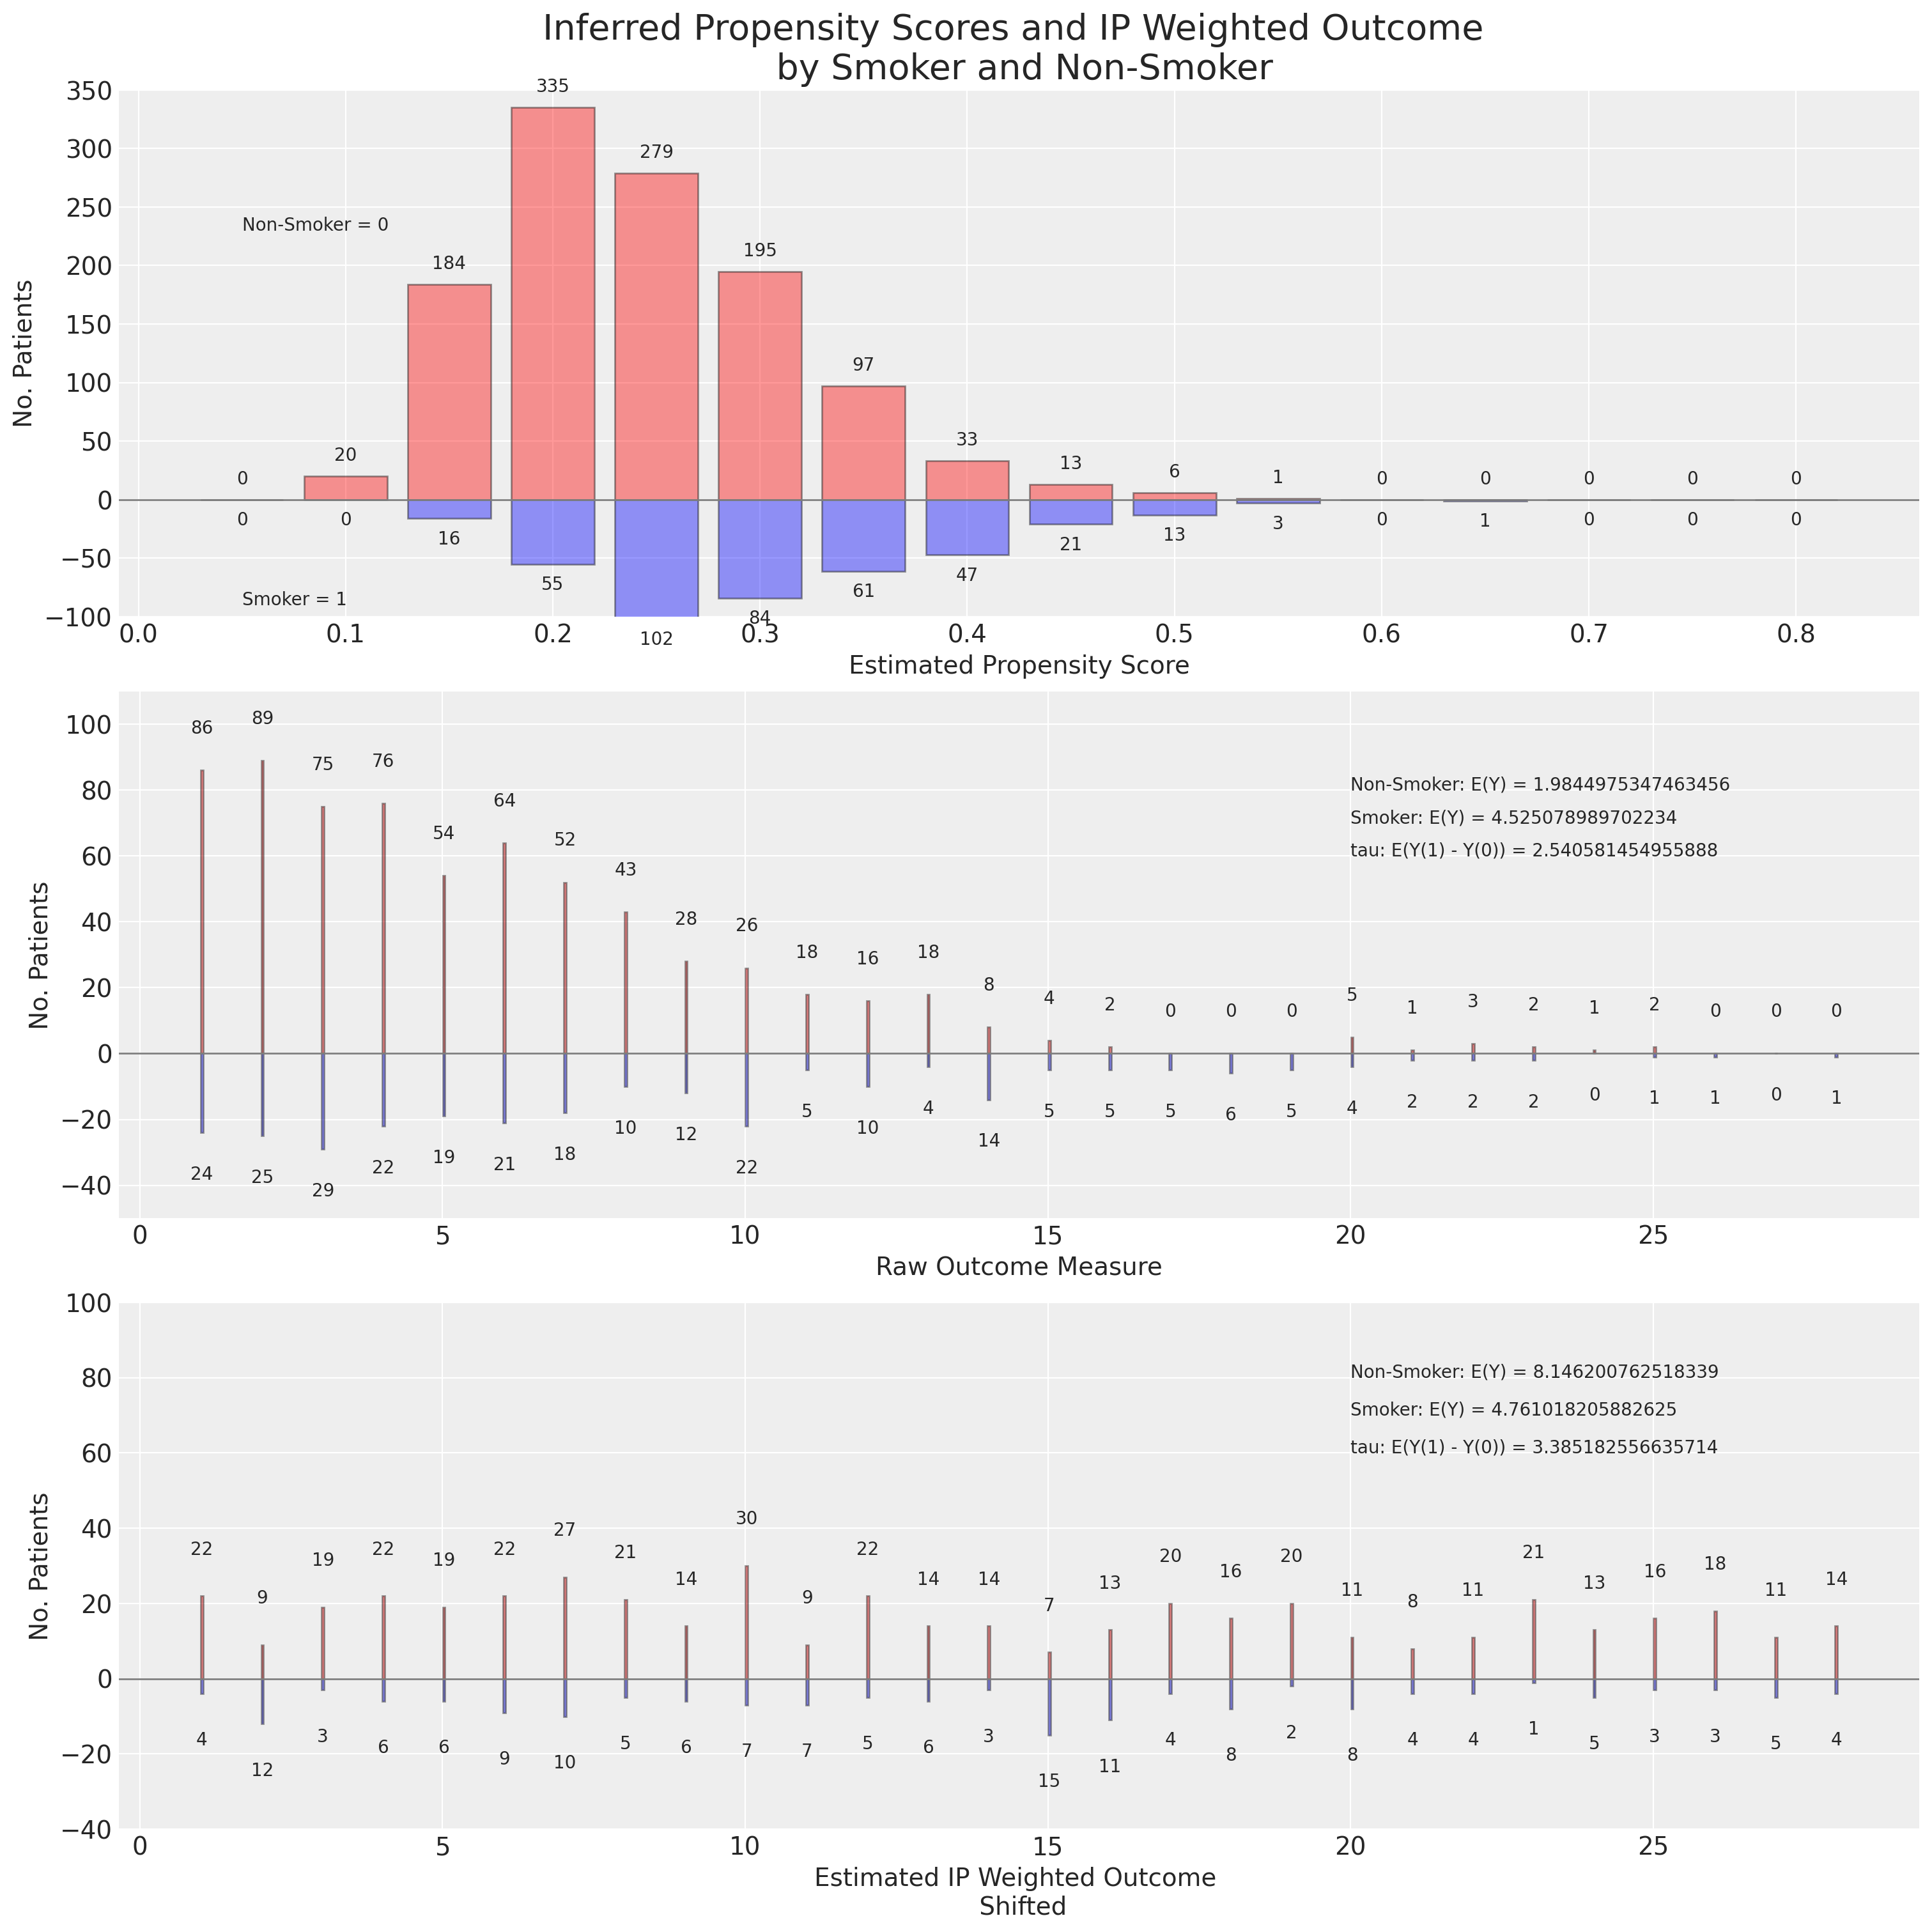

In [655]:
X['ps'] =  idata['posterior']['P'].mean(dim=('chain', 'draw')).values
X['i_ps'] =  1 / X['ps']
X['log_y'] = y
X['trt'] = t

bins = np.arange(0.025, 0.85, 0.05)
propensity0 = X[X['trt']==0]['ps']
propensity1 = X[X['trt']==1]['ps']
top0, _ = np.histogram(propensity0, bins=bins)
top1, _ = np.histogram(propensity1, bins=bins)

fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs = axs.flatten()

def plot_weights(bins, top0, top1, ylim, ax):
    ax.axhline(0, c='gray', linewidth=1)
    ax.set_ylim(ylim)
    bars0 = ax.bar(bins[:-1] + 0.025, top0, width=0.04, facecolor='red', alpha=0.4)
    bars1 = ax.bar(bins[:-1] + 0.025, -top1, width=0.04, facecolor='blue', alpha=0.4)

    for bars in (bars0, bars1):
        for bar in bars:
            bar.set_edgecolor("black")

    for x, y in zip(bins, top0):
        ax.text(x + 0.025, y + 10, str(y), ha='center', va='bottom')

    for x, y in zip(bins, top1):
        ax.text(x + 0.025, -y - 10, str(y), ha='center', va='top')

    

plot_weights(bins, top0, top1, (-100, 350), axs[0])
axs[0].text(0.05, 230, "Non-Smoker = 0")
axs[0].text(0.05, -90, "Smoker = 1")

axs[0].set_ylabel("No. Patients", fontsize=14)
axs[0].set_xlabel("Estimated Propensity Score", fontsize=14);
axs[0].set_title("Inferred Propensity Scores and IP Weighted Outcome \n by Smoker and Non-Smoker", fontsize=20);

bins = np.arange(1, 30, 1)
i_propensity0 = X[X['trt']==0]['i_ps']
i_propensity1 = X[X['trt']==1]['i_ps']
outcome_trt = X[X['trt']==1]['log_y']
outcome_ntrt = X[X['trt']==0]['log_y']
propensity0 = i_propensity0*outcome_ntrt
propensity1 = i_propensity1*outcome_trt

top0, _ = np.histogram(propensity0, bins=bins)
top1, _ = np.histogram(propensity1, bins=bins)
plot_weights(bins, top0, top1, (-40, 100), axs[2])
axs[2].set_ylabel("No. Patients", fontsize=14)
axs[2].set_xlabel("Estimated IP Weighted Outcome \n Shifted", fontsize=14);
axs[2].text(20, 80, f'Non-Smoker: E(Y) = {propensity0.sum() / len(X)}')
axs[2].text(20, 70, f'Smoker: E(Y) = {propensity1.sum() / len(X)}')
axs[2].text(20, 60, f'tau: E(Y(1) - Y(0)) = {propensity0.sum() / len(X) - propensity1.sum() / len(X)}');


top0, _ = np.histogram(outcome_ntrt, bins=bins)
top1, _ = np.histogram(outcome_trt, bins=bins)
plot_weights(bins, top0, top1, (-50, 110), axs[1])
axs[1].set_ylabel("No. Patients", fontsize=14)
axs[1].set_xlabel("Raw Outcome Measure", fontsize=14);
axs[1].text(20, 80, f'Non-Smoker: E(Y) = {outcome_ntrt.mean()}')
axs[1].text(20, 70, f'Smoker: E(Y) = {outcome_trt.mean()}')
axs[1].text(20, 60, f'tau: E(Y(1) - Y(0)) = {outcome_trt.mean() - outcome_ntrt.mean()}');

### Dirichlet Dependent Regression

In [330]:
import pymc_bart as pmb
import pytensor.tensor as pt
#X.drop('smoke', axis=1, inplace=True)
K = 20
X = X.copy().reset_index(drop=True)
t = t.copy().reset_index(drop=True)
coords={"N": np.arange(X.shape[0]), "K": np.arange(K) + 1, "one": [1]}


def norm_cdf(z):
    return 0.5 * (1 + pt.erf(z / np.sqrt(2)))

def stick_breaking(v):
    return v * pt.concatenate(
        [pt.ones_like(v[:, :1]), pt.extra_ops.cumprod(1 - v, axis=1)[:, :-1]], axis=1
    )

with pm.Model(coords=coords) as model_dpr:
    alpha = pm.Normal("alpha", 0.0, 5.0, dims="K")
    mu = pmb.BART("mu", X, t)
    p = pm.Deterministic('P', pm.math.invprobit(mu), dims='N')
    beta = pm.Normal("beta", 0.0, 5.0, dims=("one", "K"))
    y_pred = pm.Bernoulli("y_pred", p=p, observed=t)
    v = pm.Deterministic('v', norm_cdf(alpha + pm.math.dot(p[:, np.newaxis], beta)))
    w = pm.Deterministic("w", stick_breaking(v), dims=["N", "K"])
    gamma = pm.Normal("gamma", 0.0, 10.0, dims="K")
    delta = pm.Normal("delta", 0.0, 10.0, dims=("one", "K"))
    mu = pm.Deterministic("mu1", gamma + pm.math.dot(p[:, np.newaxis], delta))
    tau = pm.Gamma("tau", 1.0, 1.0, dims="K")
    y = pm.Data("y", y)
    obs = pm.NormalMixture("obs", w, mu, tau=tau, observed=y)
    
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(4000))
    idata.extend(pm.sample_posterior_predictive(idata))

pm.model_to_graphviz(model_ps)

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Sampling: [alpha, beta, delta, gamma, mu, obs, tau, y_pred]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1740: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, beta, gamma, delta, tau]
>PGBART: [mu]


KeyError: 0

## Authors
- Authored by [Nathaniel Forde](https://nathanielf.github.io/) in January 2024 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [3]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon Jan 01 2024

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.11.0

pytensor: 2.11.1

arviz     : 0.15.1
matplotlib: 3.7.1
pymc      : 5.3.0
pandas    : 1.5.3
numpy     : 1.23.5

Watermark: 2.3.1



:::{include} ../page_footer.md
:::